In [83]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [2]:
#file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
#with open(file_path, 'rb') as f:
#    data_file = maestro.DataFile.load(f.read(), file_path)

In [3]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [84]:
purs = parse_pursuit_trials.pursuitDataObject
purs.__init__(purs)
purs.setName(purs,data)
print(purs.name)

purs.pursuitData(purs,data,trialIDs=['initCoh'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[5.0,10.0,20.0], coherences=[20.0,60.0,100.0], perturbations=[]);
purs.applyRotationToData(purs)
purs.setSaccadeVelocitiesToNaN(purs)

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


Text(0, 0.5, 'Horizontal velocity (deg/s)')

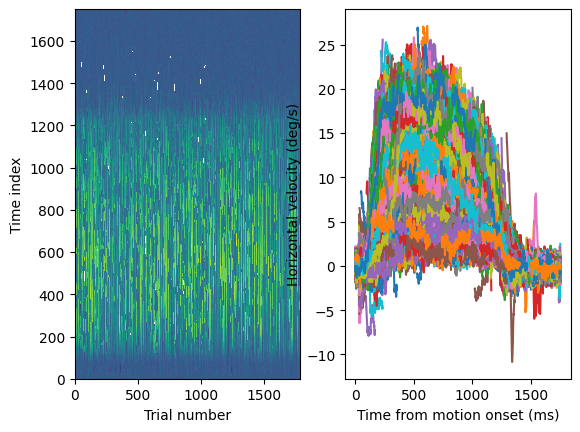

In [27]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(purs.hvelocities);
axes[0].set_xlabel('Trial number')
axes[0].set_ylabel('Time index')
axes[1].plot(purs.eye_t,purs.hvelocities);
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity (deg/s)')

In [28]:
mu, C = purs.computeMeanCov(purs.hvelocities)

print(np.shape(C))
print(np.shape(mu))

(1751, 1751)
(1751,)


Text(0, 0.5, 'Mean horizontal velocity (deg/s)')

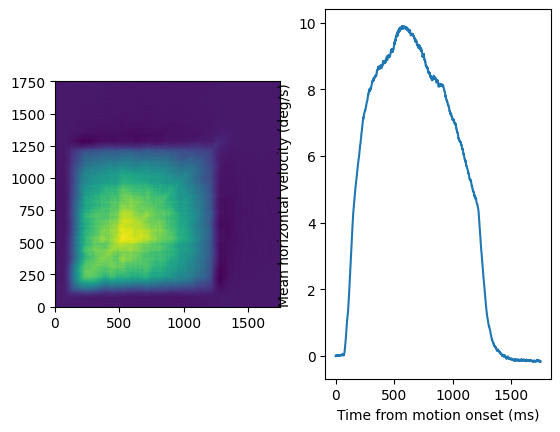

In [29]:

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(C);
axes[0].set_aspect('equal', 'box')
axes[1].plot(purs.eye_t,mu)
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Mean horizontal velocity (deg/s)')

In [43]:
x = purs.hvelocities[:,-15]
y = np.logical_not(np.isnan(x))
f = x[y]
print(x.shape)
print(mu.shape)
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y)


(1751,)
(1751,)


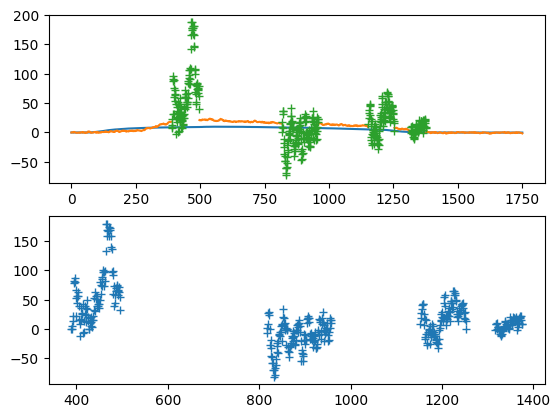

In [31]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs.eye_t,mu)
axes[0].plot(purs.eye_t,x)
axes[0].plot(purs.eye_t[np.logical_not(y)],mu_,'+')

#axes[1].plot(purs.eye_t,x-mu)
axes[1].plot(purs.eye_t[np.logical_not(y)],mu_-mu[np.logical_not(y)],'+')

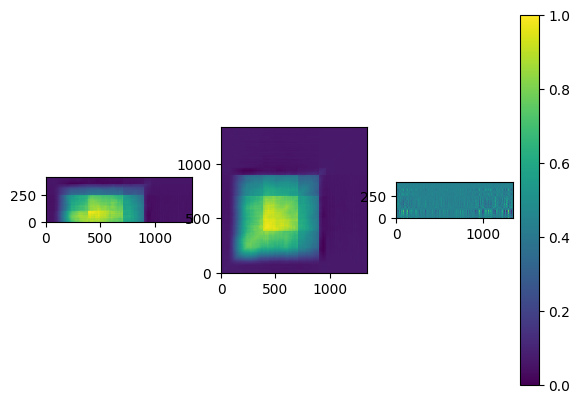

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].pcolor(C_UnObs)
axes[0].set_aspect('equal', 'box')
axes[1].pcolor(C_ObsObs)
axes[1].set_aspect('equal', 'box')
axes[2].pcolor(C_UnObs @ np.linalg.inv(C_ObsObs))
axes[2].set_aspect('equal', 'box')
fig.colorbar(plt.cm.ScalarMappable(), ax=axes[2])

In [96]:
# Test conditionalGaussian
Ntest = 100
Sig = np.ones((Ntest,Ntest))
for i in range(Ntest):
    for j in range(Ntest):
        Sig[i,j] = np.exp( -(i-j)**2/100 )

mu_test = np.zeros((Ntest,))
x = np.random.multivariate_normal(mu_test,Sig)
print(x.shape)

t = np.arange(Ntest)
y = np.ones_like(mu_test, dtype=bool)
y[0:10] = False
q = sum(np.logical_not(y))
f = x[y]
muObs = mu_test[y]
muUn = mu_test[np.logical_not(y)]

SigUnUn = Sig[0:Ntest-q,0:Ntest-q]
SigUnObs = Sig[0:Ntest-q,Ntest-q:]
SigObsObs = Sig[Ntest-q:,Ntest-q:]
SigObsUn = Sig[Ntest-q:,0:Ntest-q]

temp = SigUnObs @ np.linalg.inv(SigObsObs)
print(temp.shape)
print(f.shape)
print(muObs.shape)
mu_ = muUn + np.dot(temp, f-muObs)
#est, a, b, c = purs.conditionalGaussian(mu_test,Sig,f,x_indices=y)
print(q)
print(sum(np.logical_not(y)))

(100,)
(90, 10)
(90,)
(90,)


ValueError: shapes (90,10) and (90,) not aligned: 10 (dim 1) != 90 (dim 0)

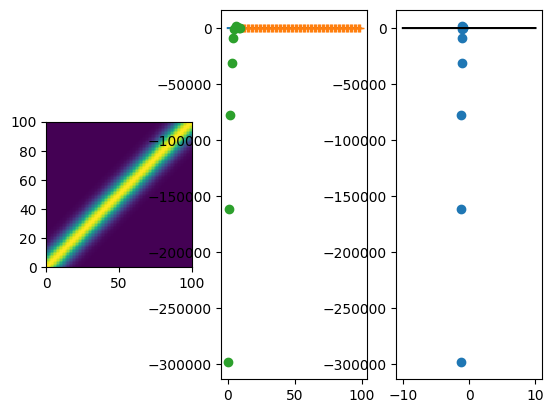

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].pcolor(Sig)
axes[0].set_aspect('equal', 'box')
axes[1].plot(t,x)
axes[1].plot(t[y],f,'+')
axes[1].plot(t[np.logical_not(y)],est,'o')
axes[2].plot(x[np.logical_not(y)],est,'o')
axes[2].plot([-10,10],[-10,10],'k')
